<a href="https://colab.research.google.com/github/Nielspace/Learning-DataScience/blob/master/05_Interpretation_of_RandomForrest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing the Libraries

In [0]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import pydotplus
from IPython import display
from io import StringIO

# Data Collection 

In [3]:
%cd drive/My\ Drive/Data\ Science

/content/drive/My Drive/Data Science


In [0]:
PATH = "data-bluebook-for-bulldozers/"

In [5]:
!ls {PATH}

'Data Dictionary.xlsx'		    Train.7z	        Valid.7z
 Machine_Appendix.csv		    TrainAndValid.7z    Valid.csv
 median_benchmark.csv		    TrainAndValid.csv   ValidSolution.csv
 random_forest_benchmark_test.csv   TrainAndValid.zip   Valid.zip
 Test.csv			    Train.csv


In [0]:
data_raw = pd.read_csv(f'{PATH}Train.csv',low_memory=False, 
                     parse_dates=["saledate"] )

## Learning the data

In [0]:
data_prac = data_raw.copy()

In [8]:
data_prac.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data_prac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null datetime64[ns]
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                

In [0]:
def assigning_categorical(data, column):
    categories = []
    for i in data[column].unique():
        categories.append(i)
    try:    
        categories.remove(np.nan)
    except Exception as e:
        pass
    data[column+'_new'] = pd.Categorical(data[column], categories=categories, ordered=True).codes
    data.drop(f'{column}', axis=1, inplace = True)
    data.replace(-1, np.nan, inplace=True)

In [0]:
for i in data_prac.columns:
    if data_prac[i].dtype == 'O':
        try:
            assigning_categorical(data_prac, i)
        except Exception as e:
            pass

In [0]:
data_prac['saleyear'] = data_prac['saledate'].dt.year
data_prac.drop('saledate', axis=1,inplace=True)

In [0]:
data_prac.SalePrice = np.log(data_prac.SalePrice)

In [0]:
for i in data_prac.columns:
    data_prac[i] = data_prac[i].fillna(data_prac[i].median())

In [0]:
X = data_prac.drop('SalePrice', axis=1)
y = data_prac.SalePrice

# Training

In [17]:
forr = RandomForestRegressor(n_jobs=-1)
%time forr.fit(X,y)
forr.score(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 4s, sys: 111 ms, total: 1min 4s
Wall time: 32.8 s


0.9817237437152007

# Creating Validation Set

In [18]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(X)-n_valid
raw_train, raw_valid = split_vals(data_prac, n_trn)
X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 52), (389125,), (12000, 52))

In [0]:
import math
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [23]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5513536884318471, 0.5727537785896973, 0.36467580537988453, 0.414153418610531]


In [0]:
import graphviz
import IPython
import re

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

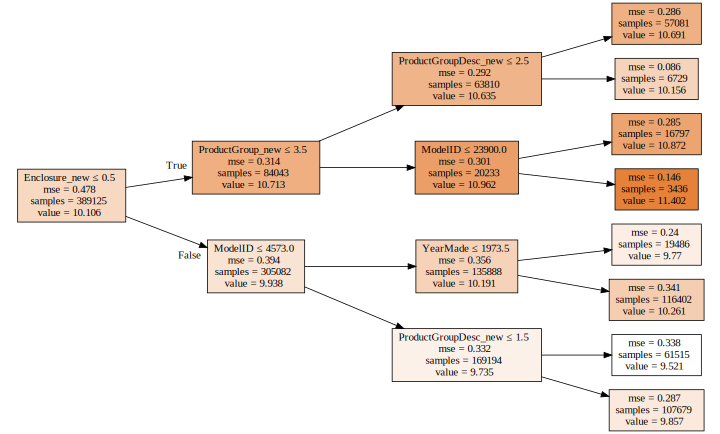

In [25]:
draw_tree(m.estimators_[0], X, precision=3)

In [26]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.09336152418133604, 0.2539493433152173, 0.9817832586311727, 0.8848292586869656]


In [27]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[:1]

(array([9.15904708, 9.02401079, 9.21034037, 9.10497986, 9.10497986,
        9.21034037, 9.10497986, 9.21034037, 9.10497986, 9.01796848]),
 9.125196689190402,
 389125    9.10498
 Name: SalePrice, dtype: float64)

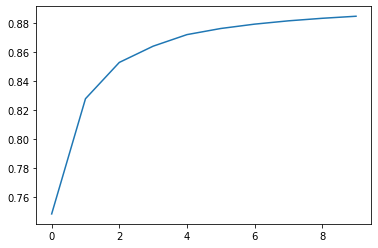

In [28]:
from sklearn.metrics import r2_score
plt.plot([r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

# Playing with hyperparameter

In [29]:
m = RandomForestRegressor(n_estimators=25, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m) #I like this model

[0.13577526456026323, 0.2373811145537504, 0.9614720287223619, 0.8993670270065851, 0.899984243945197]


In [30]:
m = RandomForestRegressor(n_estimators=30, min_samples_leaf=4, max_features='sqrt', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.19816805458174272, 0.2673043311676054, 0.9179266580330565, 0.8723972701564614, 0.876825239741552]


In [31]:
m = RandomForestRegressor(n_estimators=30, min_samples_leaf=2, max_features=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m) #not good

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.20657445683428494, 0.3032565494510219, 0.91081577040365, 0.8357640026190735, 0.8504844843571633]


In [32]:
m = RandomForestRegressor(n_estimators=20, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.13691192576310823, 0.23890307039838618, 0.9608242441511357, 0.8980724848798742, 0.8759513224545226]


# Confidence Interval

Normally, we do not just want a prediction — we also want to know how confident we are of that prediction.

What if we took the standard deviation of the predictions of the trees? If the standard deviation is high, that means each tree is giving us a very different estimate of this row’s prediction. If this was a really common kind of row, the trees would have learned to make good predictions for it because it has seen lots of opportunities to split based on those kind of rows. So the standard deviation of the predictions across the trees gives us at least relative understanding of how confident we are of this prediction.

### Standard deviation should be close to zero

In [33]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 119 ms, sys: 995 µs, total: 120 ms
Wall time: 121 ms


(9.173632091439218, 0.13778366972444908)

<center>The standard deviation is a description of the data's spread, how widely it is distributed about the mean.  A smaller standard deviation indicates that more of the data is clustered about the mean.  A larger one indicates the data are more spread out.</center>

In [0]:
raw_train, raw_valid = split_vals(data_prac, n_trn)

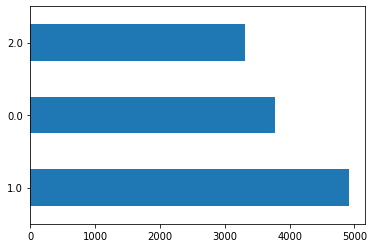

In [47]:
x = raw_valid.copy()
x['pred'] = np.std(preds, axis=0)
x['pred_std'] = np.std(preds, axis=0)
x.Enclosure_new.value_counts().plot.barh();

In [50]:
flds = ['Enclosure_new', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure_new', as_index=False).mean()
enc_summ

,Enclosure_new,SalePrice,pred,pred_std
0,0.0,10.623971,0.231293,0.231293
1,1.0,9.682133,0.191832,0.191832
2,2.0,9.849178,0.239041,0.239041


<center><b>For model interpretation, there is no need to use the full dataset because we do not need a massively accurate random forest — we just need one which indicates the nature of relationships involved</center>

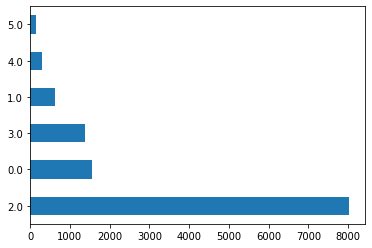

In [51]:
raw_valid.ProductSize_new.value_counts().plot.barh()

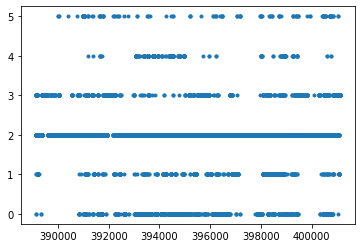

In [58]:
plt.plot(raw_valid.ProductSize_new, '.')

In [0]:
import seaborn as sb

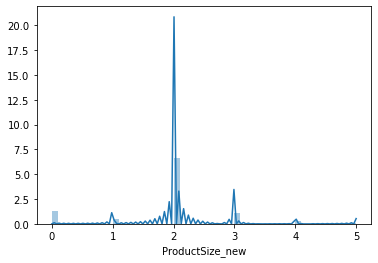

In [60]:
sb.distplot(raw_valid.ProductSize_new)

(array([1549.,    0.,  624.,    0., 8018.,    0., 1369.,    0.,  297.,
         143.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

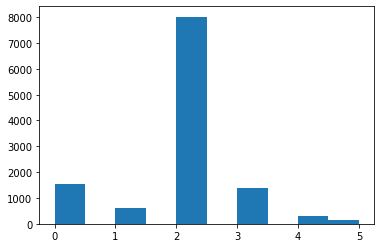

In [65]:
plt.hist(raw_valid.ProductSize_new)

# Feature Importance

In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)

In [67]:
feature_importances.head()

,importance
Enclosure_new,0.202817
YearMade,0.122691
ModelID,0.099894
ProductSize_new,0.064608
saleyear,0.064607


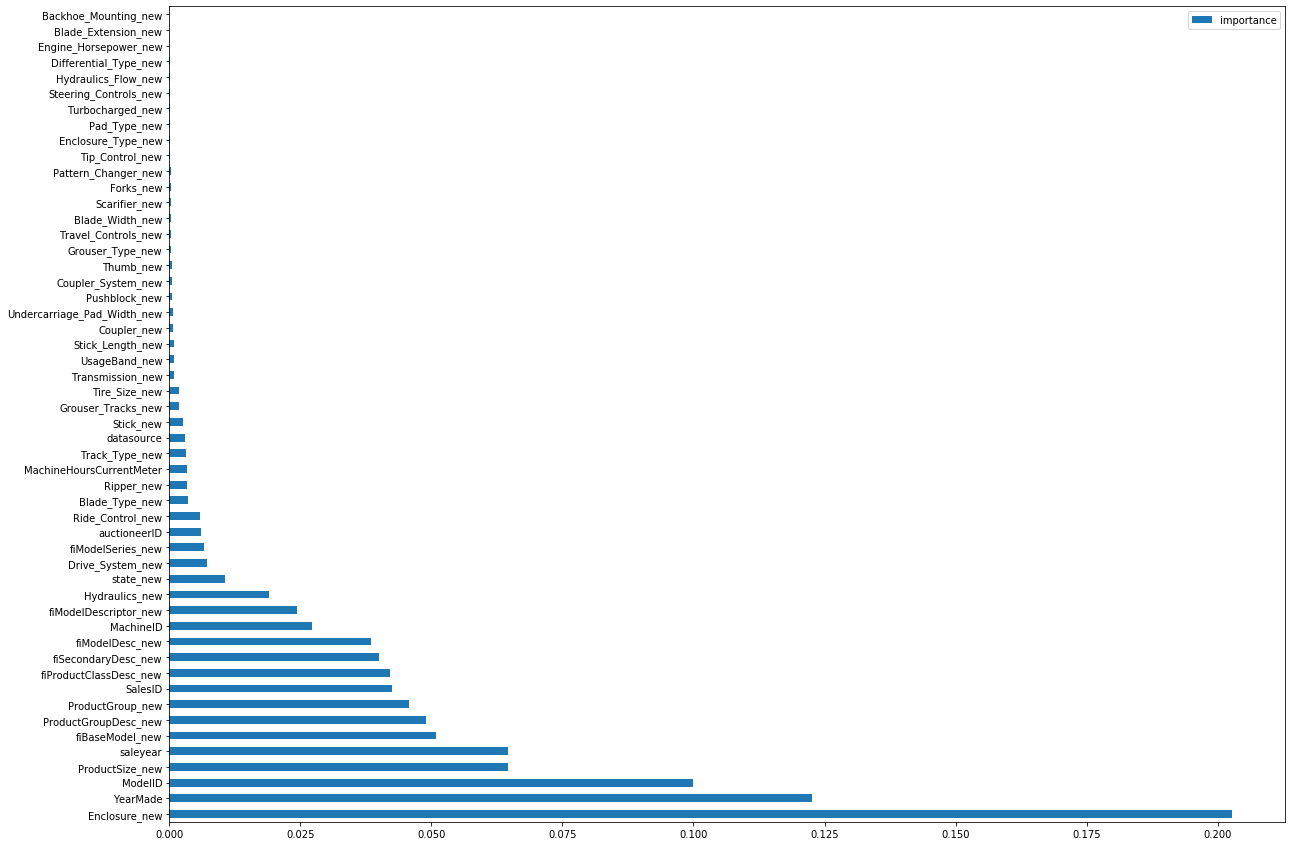

In [68]:
feature_importances.plot.barh(figsize=(20,15))

In [0]:
def to_keep(data, column, sep_value): return data.loc[data[f'{column}']>sep_value], data.loc[data[f'{column}']>sep_value].index

In [0]:
toKeep, importantCol = to_keep(feature_importances, 'importance', 0.03)

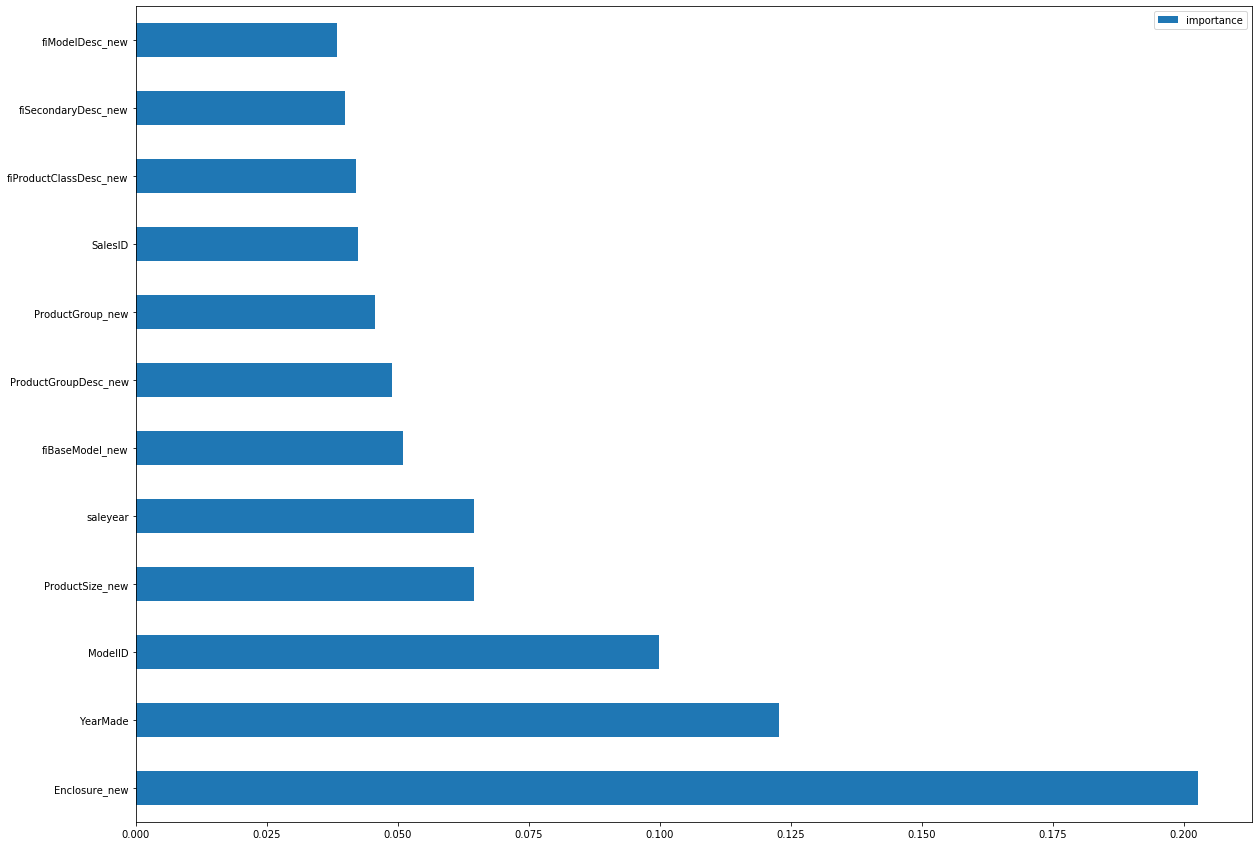

In [71]:
toKeep.plot.barh(figsize=(20,15))

In [84]:
df_keep = X[importantCol].copy(); df_keep.shape

(401125, 12)

In [0]:
X_train, X_valid = split_vals(df_keep, 30000)
y_train, y_valid = split_vals(y, 30000)

In [89]:
X_train.shape, y_train.shape

((30000, 12), (30000,))

In [112]:
m = RandomForestRegressor(n_estimators=20, min_samples_leaf=3, max_features=1, n_jobs=-1, oob_score=True, random_state=23)
%time m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


CPU times: user 601 ms, sys: 8.98 ms, total: 610 ms
Wall time: 384 ms
[0.20707245705967725, 0.5008254481046405, 0.9156090223152359, 0.4759926259694843, 0.7998867793034343]


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)

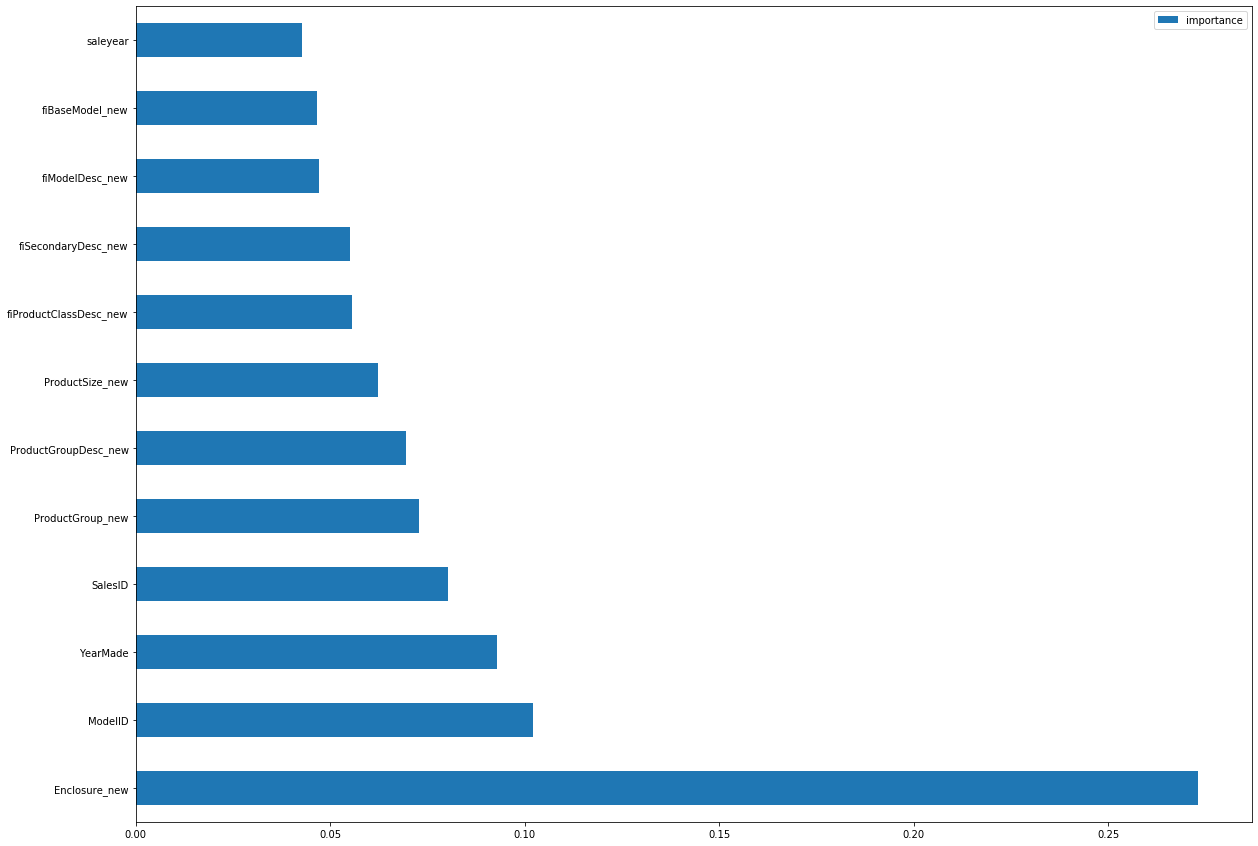

In [110]:
feature_importances.plot.barh(figsize=(20,15))